In [66]:
import os
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import time
import math
import pathlib
import pickle
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon, ttest_rel
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats, interp

from sklearn import metrics, neighbors, linear_model, preprocessing, svm
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_curve, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, KFold, StratifiedKFold,cross_val_score,GridSearchCV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from PreprocessFcns import *

from multiprocessing.dummy import Pool as ThreadPool

from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

sns.set_context('poster',font_scale=1)

In [2]:
time.sleep(3600*12)

In [3]:
def LOSOCV(Data,X,y,groups,models,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','f1','auprc','auroc'])
    groupres = {} #results on each group for each model
    

    #train multiple classifiers
    for m in models:
        acc_all=[]; acc_train=[] 
        f1_test_all=[]; prec_all=[]; rec_all=[]; spec_all=[]; auprc_all=[]; auroc_train_all=[]; 
        auroc_all=[]; fpr_all=[]; tpr_all=[]; fi_all=[]

        clf = m[0]; model_name = m[1]            
        print('Training %s'%model_name)
        s = 0
        #LOSO CV for current classifier
        for train_index, test_index in subj.split(X, y, groups):
        #leave one in:
            if LOin:
                tridx = train_index.copy()
                train_index = test_index.copy()
                test_index = tridx
            Xtr, Xte = X[train_index], X[test_index]
            ytr, yte = y[train_index], y[test_index]
            if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
                #print('only 1 class available in train data - skipping')
                continue
            clf.fit(Xtr,ytr)
            ypred = clf.predict(Xte)
            yscore = clf.predict_proba(Xte)
            yscore = yscore[:,1]
            
            #accuracy on train set
            ypred_train = clf.predict(Xtr)
            acc_train.append(sum(ypred_train==ytr)/len(ytr))
            auroc_train = roc_auc_score(ytr,clf.predict_proba(Xtr)[:,1])
            
            #f1-score, prec, recall, specificity, auprc, auroc
            f1_test_all.append(f1_score(yte,ypred))
            precision, recall, _ = precision_recall_curve(yte,yscore)
            auprc = auc(recall,precision)
            if len(np.unique(yte))>1:
                auroc = roc_auc_score(yte,yscore)
            else:
                #print('only 1 class in test data - cannot compute roc curve')
                auroc = np.nan
            spec = sum((ypred==0) & (yte==0))/sum(yte==0)


            prec_all.append(precision_score(yte,ypred))
            rec_all.append(recall_score(yte,ypred))
            auprc_all.append(auprc)
            auroc_all.append(auroc)
            auroc_train_all.append(auroc_train)
            spec_all.append(spec)

            fpr=np.linspace(0,1,101); tpr=[]

            if len(np.unique(yte))>1:                
                nscores = np.sort(np.column_stack((yscore[yte==0],yte[yte==0])),axis=0)
                neg_counts = sum(yte==0)
                for f in fpr:
                    ind = neg_counts-int(neg_counts*f)-1
                    t = (nscores[ind])[0]
                    if f==1:
                        t = 0
                    tpr_t = sum(yscore[yte==1]>t) / sum(yte==1)
                    tpr.append(tpr_t) 

            fpr = np.asarray(fpr); tpr = np.asarray(tpr)
            fpr_all.append(fpr); tpr_all.append(tpr)
            
            #store feature importance
            if model_name != 'SVM':
                fi_all.append(clf.feature_importances_)
            
            #print('\nSubj/Visit %d,prec=%.3f,rec=%.3f,Spec=%.3f,auroc_train=%.3f,auroc=%.3f'%(s,precision_score(yte,ypred),recall_score(yte,ypred),spec,auroc_train,auroc))
            s+=1

        #print('f1_test=%.3f+/-%.3f, prec=%.3f+/-%.3f, rec=%.3f+/-%.3f, auprc=%.3f+/-%.3f, auroc=%.3f+/-%.3f'%(
        #np.nanmean(f1_test_all),np.nanstd(f1_test_all),
        #np.nanmean(prec_all),np.nanstd(prec_all), np.nanmean(rec_all),np.nanstd(rec_all),
        #np.nanmean(auprc_all),np.nanstd(auprc_all), np.nanmean(auroc_all),np.nanstd(auroc_all)))
        
        #group results for each model
        groupres[model_name] = {'f1':f1_test_all, 'auprc':auprc_all, 'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all, 
                                'rec':rec_all, 'spec':spec_all, 'fi':fi_all}
        
        #mean across groups for each model
        r = pd.DataFrame({'model':model_name, 'f1':np.nanmean(f1_test_all), 'auprc':np.nanmean(auprc_all), 
                          'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
        
    return results,groupres 




def LOSOMultiClass(Data,X,y,groups,model,LOin=0):

    subj = LeaveOneGroupOut() 
    results = pd.DataFrame(data=None,columns=['model','auroc'])
    groupres = {} #results on each group for each model
    
    auroc_all = []
    tpr_all = []
    fpr_all = []
    
    clf = model[0][0]; model_name = model[0][1]          
    print('Training %s'%model_name)
    s = 0
    #LOSO CV for current classifier
    for train_index, test_index in subj.split(X, y, groups):
    #leave one in:
        if LOin:
            tridx = train_index.copy()
            train_index = test_index.copy()
            test_index = tridx
        Xtr, Xte = X[train_index], X[test_index]
        ytr, yte = y[train_index], y[test_index]
        if len(np.unique(ytr))<2: #skip if no positive or negative examples are available for training
            #print('only 1 class available in train data - skipping')
            continue
        clf.fit(Xtr,ytr)
        ypred = clf.predict(Xte)
        
#         #Round predicted scores for Regression to nearest whole number
#         if (model_name == 'Random Forest Regressor'):
#             for ypr in ypred:
#                 if ypr < 0:
#                     ypr = 0
#                 elif ypr > 4:
#                     ypr = 4
#                 else:
#                     ypr = round(ypr)
        
        yscore = clf.predict_proba(Xte)
        if len(np.unique(yte))>1:
            yte_bin = label_binarize(yte, clf.classes_)
            for c in list(range(yte_bin.shape[1]))[::-1]:
                if not any(yte_bin[:,c]):
                    yte_bin = np.delete(yte_bin,[c],axis=1)
                    yscore = np.delete(yscore,[c],axis=1)
                
            auroc = roc_auc_score(yte_bin,yscore,average='weighted')
            fpr_mean = np.array(range(0,101))/100
            tprs = []
            for i in range(yte_bin.shape[1]):
                yt = yte_bin[:,i]
                ys = yscore[:,i]
                fpr, tpr, thresh = roc_curve(yt,ys)
                tpr = interp(fpr_mean,fpr,tpr)*np.mean(yt)
                tprs.append(tpr)
                
            tpr = sum(tprs)
            fpr = fpr_mean
        else:
            #print('only 1 class in test data - cannot compute roc curve')
            auroc = np.nan
            fpr = np.array([])
            tpr = np.array([])

        tpr_all.append(tpr)
        fpr_all.append(fpr)
        auroc_all.append(auroc)
        
        r = pd.DataFrame({'model':model_name, 'auroc':np.nanmean(auroc_all)},index=[0])
        results = pd.concat((results,r))
    
    groupres[model_name] = {'auroc':auroc_all, 'tpr':tpr_all, 'fpr':fpr_all}
    
    return results, groupres

In [4]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None,ls='-',lw=3):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=lw,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=lw,linestyle=ls)
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

In [5]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

In [6]:
floatMax = np.finfo(np.float32).max
datadict = {'watch':{},'sensor':{}, 'accel':{}}
for freq in [50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Watch Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['watch'][freq] = data[data.Subject != 1020].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel+Gyro Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['sensor'][freq] = data[data.Subject != 1020].reset_index(drop=True)
for freq in [62.5,60,50,40,30,20,10,7.5,5,3]:
    data = pd.read_csv('Z:CIS-PD Study\\Downsample\\Accel Data ' + str(freq) + 'Hz.csv',index_col=0)
    for s in data.columns.values[5:]:
        data.loc[data[s]>floatMax,s] = 100
    datadict['accel'][freq] = data[data.Subject != 1020].reset_index(drop=True)

In [7]:
#Skip this cell and open pkl file

t1=time.time()
results = {}
MultiResults = {}

for mode in ['watch','sensor','accel']:

    results[mode] = {}
    MultiResults[mode] = {}

    for symptom in ['Tremor','Bradykinesia']:
        
        count = 0
        print(mode + ', ' + symptom)
        results[mode][symptom] = {}

        results[mode][symptom]['Binary'] = {}
        binary_res_all = pd.DataFrame()
        binary_res_groups = {}

        results[mode][symptom]['Multiclass'] = {}
        multi_res_all = pd.DataFrame()
        multi_res_groups = pd.DataFrame()
        MultiResults[mode][symptom] = {}

        for freq in datadict[mode].keys():

            count += 1
            print('Frequency %d of %d'%(count,len(datadict[mode].keys())))
            data = datadict[mode][freq]
            Data = data.copy() #original unmodified dataframe
            Data=Data[~Data[symptom].isnull()]
            Data=Data.reset_index(drop=True) #reset index

            if (mode == 'sensor') and (symptom == 'Tremor'):
                Data = Data.iloc[:,:49]
            
            X = Data.iloc[:,5:].values
            fnames = Data.iloc[:,5:].columns.values
            groups = Data.Subject.values

            #Binary

            y = ((Data[symptom]>0)).values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOCV(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            binary_res_all = pd.concat((binary_res_all,res))
            binary_res_groups[freq] = res_group

            print(np.nanmean(res_group['Random Forest']['auroc']))
            
            #Multiple Classes

            y = Data[symptom].values.astype(int)

            model = [RandomForestClassifier(n_estimators=50,random_state=2)]          
            model_name = ['Random Forest']
            model = list(zip(model,model_name))

            res,res_group = LOSOMultiClass(Data,X,y,groups,model)
            res['Sampling Rate'] = str(freq) + ' Hz'
            multi_res_groups = pd.concat((multi_res_groups,res))
            R = pd.DataFrame()
            R['auroc'] = [np.nanmean(multi_res_groups[multi_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['auroc'])]
            R['Model'] = ['Random Forest']
            R['Sampling Rate'] = [str(freq) + ' Hz']
            multi_res_all = pd.concat([multi_res_all,R])
            MultiResults[mode][symptom][freq] = res_group
            
            print(np.nanmean(res_group['Random Forest']['auroc']))
            
            #Regressor

#             y = Data[symptom].values.astype(int) #target 

#             model = [RandomForestRegressor(n_estimators=50,random_state=2)]          
#             model_name = ['Random Forest Regressor']
#             model = list(zip(model,model_name))

#             res,res_group = LOSOMultiClass(Data,X,y,groups,model)
#             res['Sampling Rate'] = str(freq) + ' Hz'
#             regress_res_groups = pd.concat((regress_res_groups,res))
#             R = pd.DataFrame()
#             R['RMS'] = [np.nanmean(regress_res_groups[regress_res_groups['Sampling Rate']==(str(freq) + ' Hz')]['RMS'])]
#             R['Model'] = ['Random Forest'] 
#             R['Sampling Rate'] = [str(freq) + ' Hz']
#             regress_res_all = pd.concat([regress_res_all,R])

        results[mode][symptom]['Binary']['res_all'] = binary_res_all.reset_index(drop=True)
        results[mode][symptom]['Binary']['res_groups'] = binary_res_groups
        
        results[mode][symptom]['Multiclass']['res_all'] = multi_res_all.reset_index(drop=True)
        results[mode][symptom]['Multiclass']['res_groups'] = multi_res_groups
        
#         results[mode][symptom]['Regressor']['res_all'] = regress_res_all.reset_index(drop=True)
#         results[mode][symptom]['Regressor']['res_groups'] = regress_res_groups
        
f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\DownsampleAnalysisResults','wb')
pickle.dump((results, MultiResults),f)
f.close()

print('Elapsed time = %.3f min'%((time.time()-t1)/60))    

watch, Tremor
Frequency 1 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.787656450752749
Training Random Forest
0.7669120384155796
Frequency 2 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7861718170944592
Training Random Forest
0.7653379933499848
Frequency 3 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7780236960194968
Training Random Forest
0.757980885564569
Frequency 4 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7492841581542272
Training Random Forest
0.7231084024055745
Frequency 5 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7292544907135764
Training Random Forest
0.7058556297785269
Frequency 6 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7284170275400342
Training Random Forest
0.6965098174958225
Frequency 7 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.708344028138725
Training Random Forest
0.6820595951329179
Frequency 8 of 8
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.6570024985376915
Training Random Forest
0.6437390980075441
watch, Bradykinesia
Frequency 1 of 8
Training Random Forest
0.6292112567137017
Training Random Forest
0.6096379358015418
Frequency 2 of 8
Training Random Forest
0.6302797274240568
Training Random Forest
0.6104884776841488
Frequency 3 of 8
Training Random Forest
0.6196893167196136
Training Random Forest
0.6159010983244484
Frequency 4 of 8
Training Random Forest
0.6389958844176665
Training Random Forest
0.6148053125022559
Frequency 5 of 8
Training Random Forest
0.6575155907536863
Training Random Forest
0.6222986138730294
Frequency 6 of 8
Training Random Forest
0.6455026860484108
Training Random Forest
0.610826377565915
Frequency 7 of 8
Training Random Forest
0.6745928519803345
Training Random Forest
0.6261223312222899
Frequency 8 of 8
Training Random Forest
0.6688857549679711
Training Random Forest
0.6159836639685612
sensor, Tremor
Frequency 1 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.77173230016089
Training Random Forest
0.7536722151009357
Frequency 2 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.767744218033747
Training Random Forest
0.7491856402151171
Frequency 3 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7654450214870002
Training Random Forest
0.7528591550467247
Frequency 4 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7679974300559919
Training Random Forest
0.749491252710831
Frequency 5 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7689370720905905
Training Random Forest
0.7465448397348707
Frequency 6 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7493571287621127
Training Random Forest
0.7413445041550388
Frequency 7 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.717705274997055
Training Random Forest
0.6949045950001983
Frequency 8 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7012811897303594
Training Random Forest
0.681058299379993
Frequency 9 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.6914049012575562
Training Random Forest
0.6817570596152893
Frequency 10 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.5656310537894474
Training Random Forest
0.5737778272972504
sensor, Bradykinesia
Frequency 1 of 10
Training Random Forest
0.6826142393768312
Training Random Forest
0.6455424072971844
Frequency 2 of 10
Training Random Forest
0.6740457922059039
Training Random Forest
0.647118167290041
Frequency 3 of 10
Training Random Forest
0.6778882072181242
Training Random Forest
0.6499160793915773
Frequency 4 of 10
Training Random Forest
0.6763693303637137
Training Random Forest
0.6500008481665412
Frequency 5 of 10
Training Random Forest
0.6753341067784728
Training Random Forest
0.6472999992023376
Frequency 6 of 10
Training Random Forest
0.6735619299628369
Training Random Forest
0.6480509737569877
Frequency 7 of 10
Training Random Forest
0.6763977312679402
Training Random Forest
0.6425476518738139
Frequency 8 of 10
Training Random Forest
0.6860246741368757
Training Random Forest
0.6515439464369355
Frequency 9 of 10
Training Random Forest
0.6739373597549954
Training Random Forest
0.6517253279922078
F

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7621039018630776
Training Random Forest
0.7382666839094648
Frequency 2 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7596423235026196
Training Random Forest
0.7446292708111736
Frequency 3 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7619621515012471
Training Random Forest
0.7476406796280567
Frequency 4 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7620771104731808
Training Random Forest
0.7476027633477718
Frequency 5 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7611667955851841
Training Random Forest
0.7433831229409266
Frequency 6 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.751743754829678
Training Random Forest
0.7250025272322209
Frequency 7 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7276313631443444
Training Random Forest
0.6963542213498953
Frequency 8 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7170678059649124
Training Random Forest
0.6919383189113161
Frequency 9 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.7038278100321902
Training Random Forest
0.6972407162981636
Frequency 10 of 10
Training Random Forest


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\ranking.py:113: RuntimeWarning: invalid value encountered in less
  if np.any(dx < 0):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


0.5656310537894474
Training Random Forest
0.5737778272972504
accel, Bradykinesia
Frequency 1 of 10
Training Random Forest
0.6384062418026217
Training Random Forest
0.6203405013636905
Frequency 2 of 10
Training Random Forest
0.640624479174831
Training Random Forest
0.6203602604565535
Frequency 3 of 10
Training Random Forest
0.6388283305289695
Training Random Forest
0.6156159247606948
Frequency 4 of 10
Training Random Forest
0.6413768921776126
Training Random Forest
0.6168197853095753
Frequency 5 of 10
Training Random Forest
0.6435218791062804
Training Random Forest
0.615009635667538
Frequency 6 of 10
Training Random Forest
0.6465441731283559
Training Random Forest
0.6194649871362637
Frequency 7 of 10
Training Random Forest
0.6564583245451543
Training Random Forest
0.6283385417107972
Frequency 8 of 10
Training Random Forest
0.6505531506464766
Training Random Forest
0.6264646365427564
Frequency 9 of 10
Training Random Forest
0.6726730362052622
Training Random Forest
0.6360826282986215
Fre

In [8]:
res_group['Random Forest'].keys()

dict_keys(['auroc', 'tpr', 'fpr'])

In [9]:
f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\DownsampleAnalysisResults','wb')
pickle.dump((results, MultiResults),f)
f.close()

In [10]:
#Open results as pickle file

f = open('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Results\\DownsampleAnalysisResults','rb')
(results, MultiResults) = pickle.load(f)
f.close()

In [11]:
def plotFrequencies(mode,symptom,classifier,ax=None,c='b'):
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    
    AUROCs = [(g,np.nanmean(AUC[g])) for g in groups if g!=60 and g!=3]
    AUC_subject_means = np.nanmean([AUC[g] for g in groups],axis=0)
    diffs = [[i-j for i,j in zip(AUC[g],AUC_subject_means)] for g in groups[1:]]
    diff_sem = np.nanmean([stats.sem(diffs[i],nan_policy='omit') for i in range(len(diffs))])
    CI_top = stats.sem(np.hstack(diffs),nan_policy='omit')*1.98#+np.nanmean(diffs)
    CI_bottom = stats.sem(np.hstack(diffs),nan_policy='omit')*-1.98#+np.nanmean(diffs)
    print(np.nanpercentile(np.hstack(diffs),5),np.nanpercentile(np.hstack(diffs),95))
    SEM_top = stats.sem(AUC[max(groups)],nan_policy='omit')
    AUROCs = np.array(AUROCs)
#     print(AUROCs)

    
    ax = sns.lineplot(AUROCs[:,0],AUROCs[:,1],ax=ax,lw=5,legend='full',color=c)
    sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+diff_sem*1.98]*2,ax=ax,lw=3,color=c)
    sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]-diff_sem*1.98]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+CI_top]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+CI_bottom]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]+stats.sem(AUROCs[:,1],nan_policy='omit')*1.98]*2,ax=ax,lw=3,color=c)
#     sns.lineplot([AUROCs[0,0], AUROCs[-1,0]],[AUROCs[0,1]-stats.sem(AUROCs[:,1],nan_policy='omit')*1.98]*2,ax=ax,lw=3,color=c)
    return ax

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


-0.1389436075115438 0.06310005296278892
-0.14566951164290481 0.07946828483267385


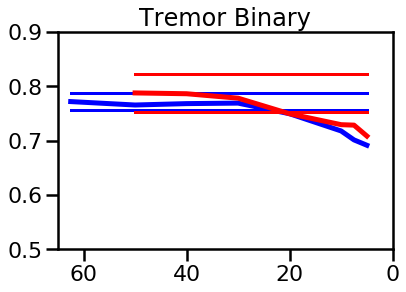

In [12]:
ax = plotFrequencies('sensor','Tremor','Binary',c='b')
plotFrequencies('watch','Tremor','Binary',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Tremor Binary')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Tremor_BinaryDown.svg')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


-0.1254237769870028 0.06100437261032235
-0.09943180764675753 0.07150455109018596


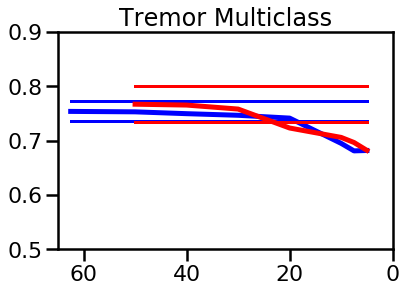

In [13]:
ax = plotFrequencies('sensor','Tremor','Multiclass',c='b')
plotFrequencies('watch','Tremor','Multiclass',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Tremor Multiclass')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Tremor_MulticlassDown.svg')

-0.06088849467310393 0.03792938422674541
-0.0513543126114904 0.09011609505091447


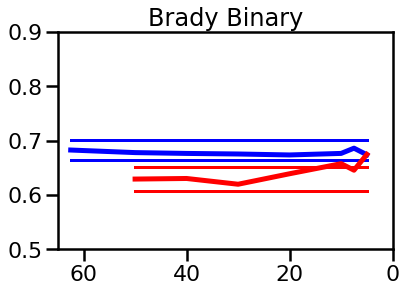

In [14]:
ax = plotFrequencies('sensor','Bradykinesia','Binary',c='b')
plotFrequencies('watch','Bradykinesia','Binary',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Brady Binary')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Brady_BinaryDown.svg')

-0.04312968651371007 0.034997112155156745
-0.04545805057508559 0.04192430291454802


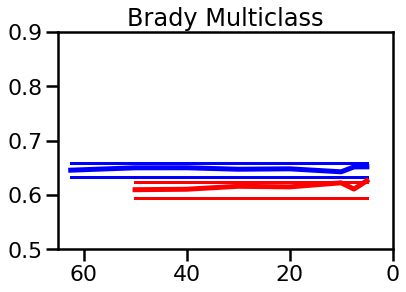

In [15]:
ax = plotFrequencies('sensor','Bradykinesia','Multiclass',c='b')
plotFrequencies('watch','Bradykinesia','Multiclass',c='r')
plt.ylim([.5,.9])
plt.xlim([65,0])
plt.title('Brady Multiclass')
plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Brady_MulticlassDown.svg')

In [16]:
def FreqSelection(mode,symptom,classifier,CIBound=False,CIZ=1.98,tol=.05):
    
    # Set plot parameters
    plotStyles = ['-', '--', (0,(3,10)), '-.', (0,(3,5,1,5)), (0,(3,10,1,10)), ':', (0, (1, 10))]
    plotCol = ['b', 'r', 'g', 'c', 'm', 'y', 'k', 'b']
    lw=5
    plt.figure(figsize=(12,9))
    
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
    
    done = False
    freq = max(groups)
    
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']

    current_auc = AUC[freq]
      
    freqInd = 0
    plotInd = 0
    ast = ''
        
    ax = plot_roc(np.vstack([d for d in data[freq]['Random Forest']['tpr'] if len(d)>0]),
                  data[freq]['Random Forest']['fpr'][0],np.nanmean(AUC[freq].values),
                  plotname=str(freq) + ' Hz',col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
    
    for freqInd in range(1,len(groups)):
        freq = groups[freqInd]
        if freq==60 or freq==3:
            continue
            
        auc_groups = (AUC[freq].mean()-np.nanmean(current_auc))/(np.nanmean(current_auc))
        print(freq,auc_groups)
#         auc_sem = stats.sem(AUC[freq].values-current_auc, nan_policy='omit')
#         print('%.1f\t%.3f (%.3f, %.3f)'%(freq,auc_groups,auc_groups-1.98*auc_sem,auc_groups+1.98*auc_sem))
        if done:
            continue
        
#         gate = auc_groups+(CIZ*auc_sem)>0
        gate = auc_groups>-.025
        if auc_groups>0:
            current_auc = AUC[freq]
        
#         if not gate:
#             done = True
        
        plotInd+=1
        
        plot_roc(np.vstack([d for d in data[freq]['Random Forest']['tpr'] if len(d)>0]),
                 data[freq]['Random Forest']['fpr'][0],np.nanmean(AUC[freq].values),
                 plotname=str(freq) + ' Hz'+ast,col = plotCol[plotInd], ls = plotStyles[plotInd], lw=lw)
        
    
    plt.xlim(0,1)
    plt.ylim(0,1)
    ax.set_xlabel(ax.get_xlabel(), fontsize=30)
    ax.set_ylabel(ax.get_ylabel(), fontsize=30)
    ax.legend(loc=4,fontsize=22)
    
    plt.savefig('C:\\Users\\nshawen\\Box\\CIS-PD Optimization\\Images\\Downsampling\\' + mode + '-' + symptom + '-' + classifier + '.svg')

In [28]:
def printCIs(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = list(results[mode][symptom][classifier]['res_groups'].keys())
        data = results[mode][symptom][classifier]['res_groups']
    else:
        groups = list(MultiResults[mode][symptom].keys())
        data = MultiResults[mode][symptom]
        
    AUC = pd.DataFrame()
    if classifier == 'Binary':
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
    else:
        for g in groups:
            AUC[g] = data[g]['Random Forest']['auroc']
            
    for g in AUC.keys():
        auc_groups = AUC[g].mean()
        auc_sem = stats.sem(AUC[g].values, nan_policy='omit')
        print('%.1f\t%.2f (%.2f, %.2f)'%(g,auc_groups,auc_groups-1.98*auc_sem,auc_groups+1.98*auc_sem))

50 -0.00018599873519080005
40 -3.5154510863035776e-05
30 -0.0012296305997159798
20 -0.013594139864751597
10 -0.045233384364599304
7.5 -0.05909443028446351
5 -0.07646738415644215


62.5	0.76 (0.66, 0.86)
60.0	0.76 (0.66, 0.86)
50.0	0.76 (0.67, 0.86)
40.0	0.76 (0.67, 0.86)
30.0	0.76 (0.66, 0.86)
20.0	0.75 (0.65, 0.85)
10.0	0.73 (0.64, 0.82)
7.5	0.72 (0.63, 0.81)
5.0	0.70 (0.62, 0.79)
3.0	0.57 (0.50, 0.63)


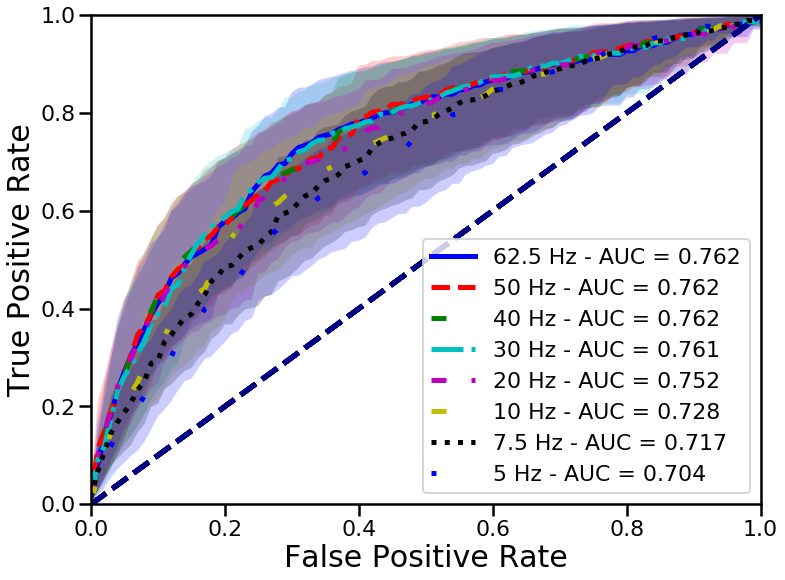

In [29]:
FreqSelection('accel','Tremor','Binary',True)
print('\n')
printCIs('accel','Tremor','Binary')

50 0.012697302916274397
40 -5.0714576290573235e-05
30 -0.005694656274252246
20 -0.03027945510816508
10 -0.06859773642022239
7.5 -0.07450418661602487
5 -0.0674120131544561


62.5	0.74 (0.65, 0.83)
60.0	0.74 (0.66, 0.83)
50.0	0.75 (0.66, 0.83)
40.0	0.75 (0.66, 0.83)
30.0	0.74 (0.66, 0.83)
20.0	0.73 (0.64, 0.81)
10.0	0.70 (0.62, 0.78)
7.5	0.69 (0.61, 0.77)
5.0	0.70 (0.62, 0.78)
3.0	0.57 (0.52, 0.62)


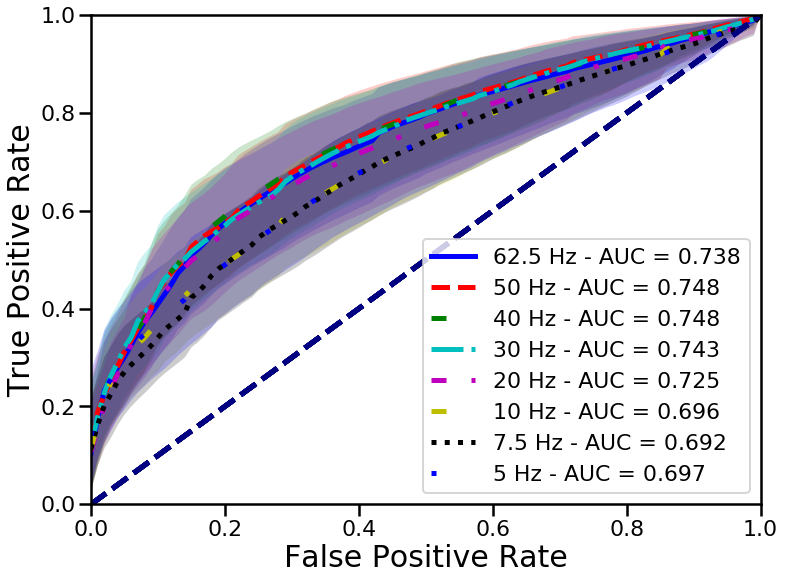

In [30]:
FreqSelection('accel','Tremor','Multiclass',True)
print('\n')
printCIs('accel','Tremor','Multiclass')

50 -0.00814696841453833
40 -0.004839592827875322
30 -0.0036220177252098977
20 -0.028993436446955196
10 -0.07000746910887551
7.5 -0.09128957076934978
5 -0.10408712825235807


62.5	0.77 (0.68, 0.86)
60.0	0.77 (0.68, 0.86)
50.0	0.77 (0.67, 0.86)
40.0	0.77 (0.68, 0.86)
30.0	0.77 (0.68, 0.86)
20.0	0.75 (0.65, 0.85)
10.0	0.72 (0.62, 0.81)
7.5	0.70 (0.61, 0.79)
5.0	0.69 (0.60, 0.78)
3.0	0.57 (0.50, 0.63)


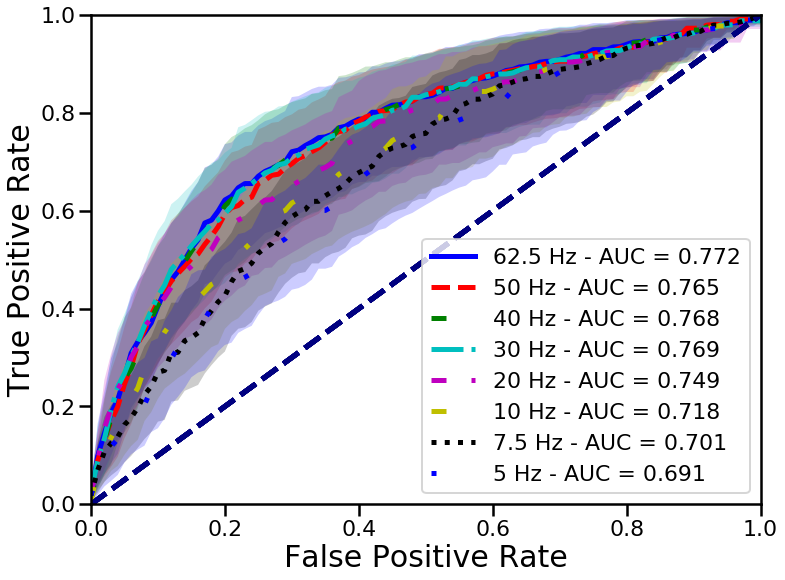

In [31]:
FreqSelection('sensor','Tremor','Binary',True)
print('\n')
printCIs('sensor','Tremor','Binary')

50 -0.0010787979680292603
40 -0.00554745459144312
30 -0.00945686363814071
20 -0.016356860049890558
10 -0.0779750386484222
7.5 -0.09634681266738478
5 -0.09541967190075484


62.5	0.75 (0.68, 0.83)
60.0	0.75 (0.67, 0.83)
50.0	0.75 (0.67, 0.83)
40.0	0.75 (0.67, 0.83)
30.0	0.75 (0.66, 0.83)
20.0	0.74 (0.65, 0.83)
10.0	0.69 (0.62, 0.77)
7.5	0.68 (0.60, 0.76)
5.0	0.68 (0.60, 0.76)
3.0	0.57 (0.52, 0.62)


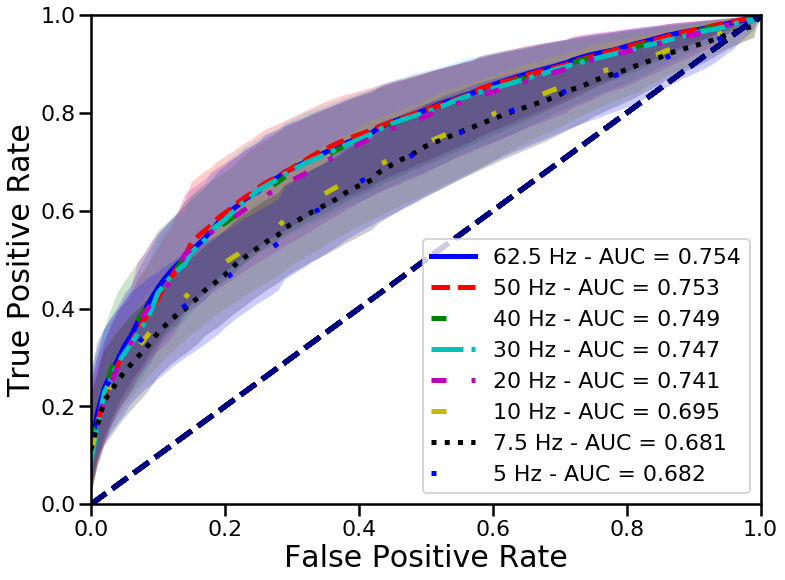

In [32]:
FreqSelection('sensor','Tremor','Multiclass',True)
print('\n')
printCIs('sensor','Tremor','Multiclass')

50 -0.006923430374118044
40 -0.009148518523168435
30 -0.010665075790104379
20 -0.013261237301844529
10 -0.0091069124408628
7.5 0.004996137735359845
5 -0.017619358074967305


62.5	0.68 (0.62, 0.75)
60.0	0.67 (0.61, 0.73)
50.0	0.68 (0.62, 0.74)
40.0	0.68 (0.61, 0.74)
30.0	0.68 (0.61, 0.74)
20.0	0.67 (0.61, 0.74)
10.0	0.68 (0.61, 0.74)
7.5	0.69 (0.62, 0.75)
5.0	0.67 (0.60, 0.74)
3.0	0.68 (0.62, 0.73)


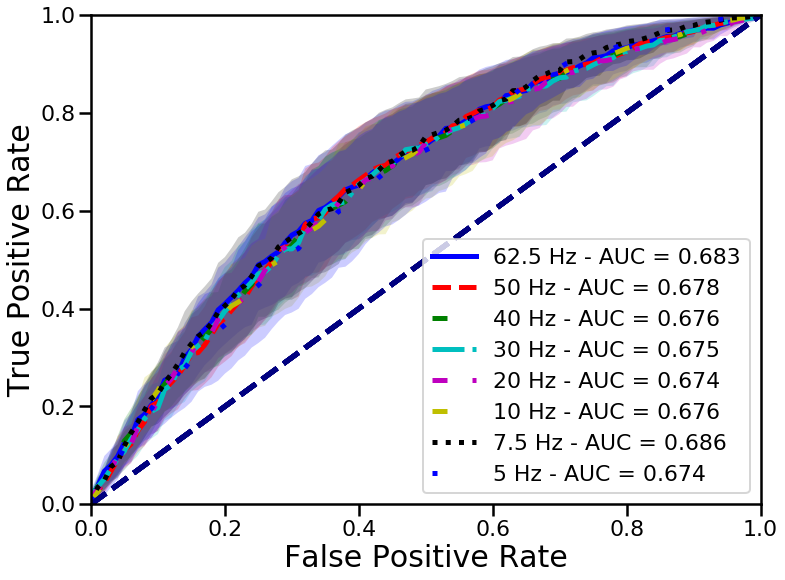

In [33]:
FreqSelection('sensor','Bradykinesia','Binary',True)
print('\n')
printCIs('sensor','Bradykinesia','Binary')

50 0.006775189429777302
40 0.00013043033962667993
30 -0.0041551468306877115
20 -0.0029998028695709168
10 -0.011466440872732065
7.5 0.002373994241310374
5 0.0002783872926212821


62.5	0.65 (0.59, 0.70)
60.0	0.65 (0.59, 0.71)
50.0	0.65 (0.60, 0.70)
40.0	0.65 (0.60, 0.70)
30.0	0.65 (0.59, 0.70)
20.0	0.65 (0.59, 0.70)
10.0	0.64 (0.58, 0.70)
7.5	0.65 (0.60, 0.70)
5.0	0.65 (0.60, 0.71)
3.0	0.63 (0.58, 0.68)


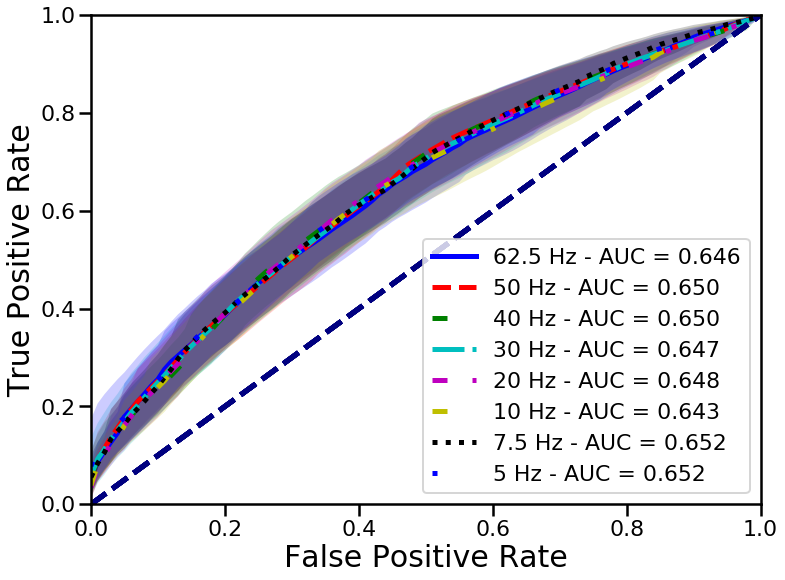

In [34]:
FreqSelection('sensor','Bradykinesia','Multiclass',True)
print('\n')
printCIs('sensor','Bradykinesia','Multiclass')

40 -0.001884874626330974
30 -0.01222963986906519
20 -0.04871704226106487
10 -0.07414648859075418
7.5 -0.07520972266030547
5 -0.10069418277248503


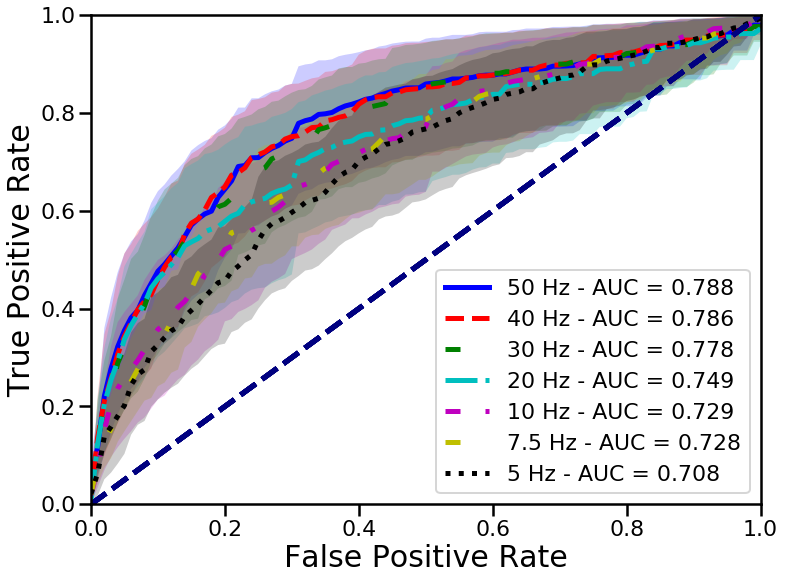

In [24]:
FreqSelection('watch','Tremor','Binary',True)

40 -0.0020524453741094257
30 -0.011645602629295098
20 -0.05711689713529901
10 -0.07961331362485026
7.5 -0.09179960333548327
5 -0.11064168904945693


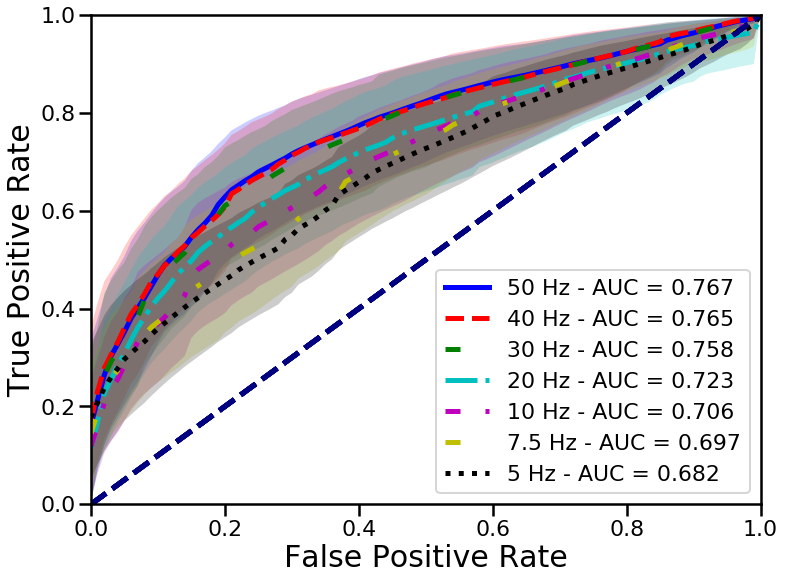

In [25]:
FreqSelection('watch','Tremor','Multiclass',True)

40 0.0016981112447599811
30 -0.01680271511781929
20 0.013829029579029524
10 0.028982512700996853
7.5 -0.018270144273697813
5 0.02597240501487298


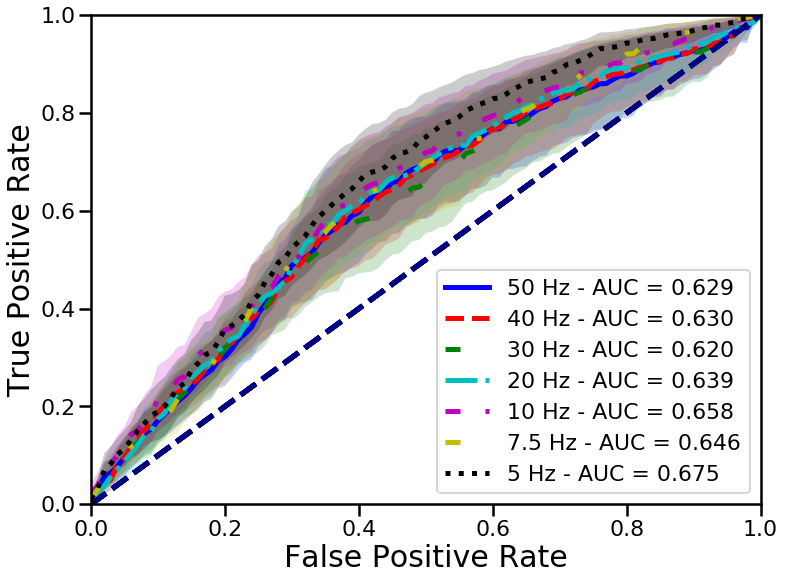

In [26]:
FreqSelection('watch','Bradykinesia','Binary',True)

40 0.0013951590487700657
30 0.00886604880870519
20 -0.0017791587402158705
10 0.010387244909913945
7.5 -0.018435259297323786
5 0.006144505650531032


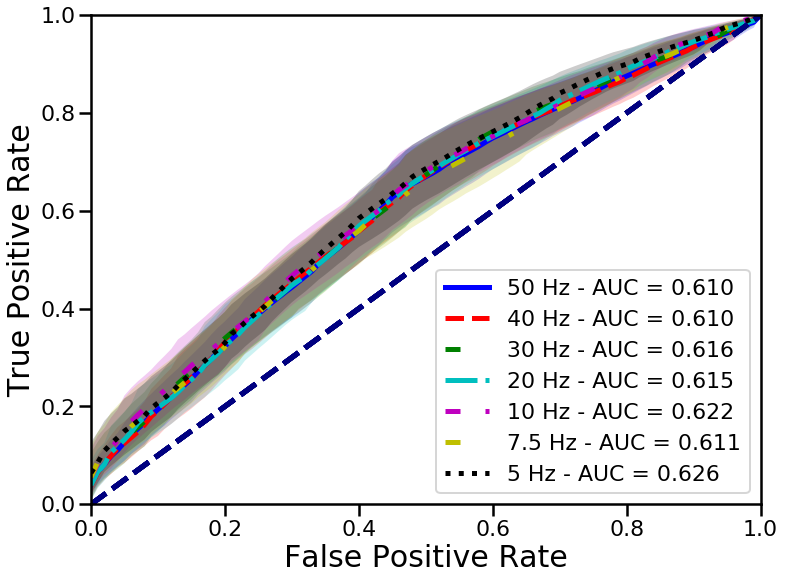

In [27]:
FreqSelection('watch','Bradykinesia','Multiclass',True)

In [101]:
def PairedT(A,B):
    A = np.array(A); B = np.array(B)
    inds = np.isnan(A) | np.isnan(B)
    inds = np.array(~inds)
    return ttest_rel(A[inds],B[inds])

def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[col])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return F,stats.f.sf(F,dfbw,dferror)

def HBCorrections(df,comps,target=.05):
    res = []
    for pair in comps:
        p = PairedT(df[pair[0]].values, df[pair[1]].values)[1]
        res.append((p,str(pair[0])+'+'+str(pair[1])))
    
    res = sorted(res)
    dec = 'Reject'
    for r,i in zip(res,range(1,len(res)+1)):
        thresh = target/(len(res)-i+1)
        if r[0]<thresh and dec=='Reject':
            dec = 'Reject'
        else:
            dec = 'Accept'
        print('%s%.3f\t%.3f\t%s'%(r[1]+' '*(13-len(r[1])),r[0],thresh,dec))

In [130]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Tremor']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(43.62959927165707, 1.3959776094786654e-30)

In [131]:
HBCorrections(D,[(62.5,30),(62.5,20),(62.5,10),(62.5,7.5),(62.5,5)])


62.5+5       0.000	0.010	Reject
62.5+10      0.000	0.013	Reject
62.5+7.5     0.000	0.017	Reject
62.5+20      0.023	0.025	Reject
62.5+30      0.424	0.050	Accept


In [104]:
D = pd.DataFrame(data = np.vstack([MultiResults['sensor']['Tremor'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(27.81633194751286, 2.142706777695941e-23)

In [108]:
HBCorrections(D,[(62.5,20),(62.5,10),(62.5,7.5),(62.5,5),
                 (5,10),(5,20),(5,30),(5,40),(5,50)])

62.5+7.5     0.000	0.006	Reject
62.5+10      0.000	0.006	Reject
5+50         0.001	0.007	Reject
62.5+5       0.001	0.008	Reject
5+40         0.001	0.010	Reject
5+30         0.004	0.013	Reject
5+20         0.008	0.017	Reject
62.5+20      0.185	0.025	Accept
5+10         0.501	0.050	Accept


In [82]:
D = pd.DataFrame(data = np.vstack([results['sensor']['Bradykinesia']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.12135052537068233, 0.9991024266247786)

In [83]:
D = pd.DataFrame(data = np.vstack([MultiResults['sensor']['Bradykinesia'][freq]['Random Forest']['auroc']
                                   for freq in datadict['sensor'].keys()]).transpose(), 
                 columns = datadict['sensor'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.8681496743260243, 0.5559821532038978)

In [116]:
D = pd.DataFrame(data = np.vstack([results['watch']['Tremor']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(4.467352607773666, 0.00032451800967158454)

In [118]:
HBCorrections(D,[(50,20),(50,10),(50,7.5),(50,5),
                 (5,20),(5,30),(5,40)])

50+7.5       0.001	0.007	Reject
50+10        0.002	0.008	Reject
5+40         0.003	0.010	Reject
50+5         0.003	0.013	Reject
5+30         0.015	0.017	Reject
50+20        0.131	0.025	Accept
5+20         0.310	0.050	Accept


In [119]:
D = pd.DataFrame(data = np.vstack([MultiResults['watch']['Tremor'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(4.968183652656898, 0.00011278501061902211)

In [120]:
HBCorrections(D,[(50,20),(50,10),(50,7.5),(50,5),
                 (5,20),(5,30),(5,40)])

50+5         0.000	0.007	Reject
5+40         0.000	0.008	Reject
5+30         0.001	0.010	Reject
50+7.5       0.003	0.013	Reject
50+10        0.005	0.017	Reject
50+20        0.183	0.025	Accept
5+20         0.223	0.050	Accept


In [121]:
D = pd.DataFrame(data = np.vstack([results['watch']['Bradykinesia']['Binary']['res_groups'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(2.694902774992843, 0.01437987774271021)

In [128]:
HBCorrections(D,[(50,5)])

50+5         0.192	0.050	Accept


In [127]:
D = pd.DataFrame(data = np.vstack([MultiResults['watch']['Bradykinesia'][freq]['Random Forest']['auroc']
                                   for freq in datadict['watch'].keys()]).transpose(), 
                 columns = datadict['watch'].keys())
D.dropna(inplace=True)
rmANOVA(D,list(D.columns))

(0.48664692782245206, 0.8418047166520746)

IndexError: string index out of range

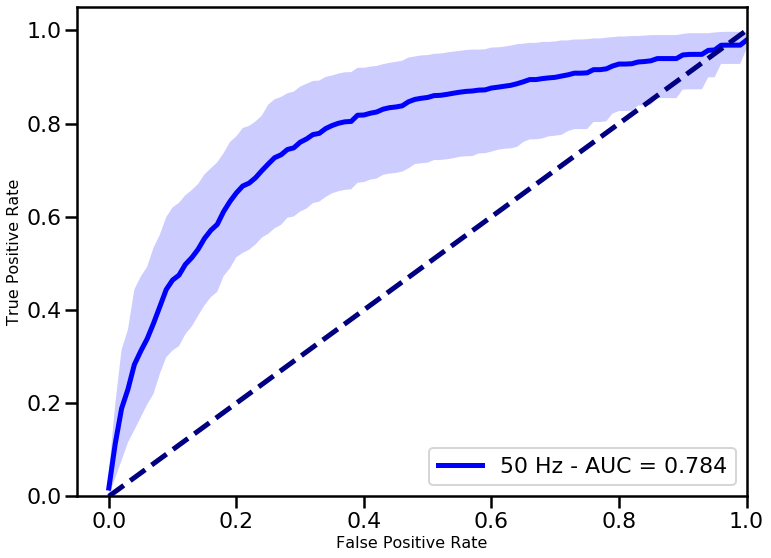

In [47]:
lw = 5
ls = '-'
col = ['b', 'r', ]

for mode in ['watch','sensor']:

    for symptom in ['Tremor','Bradykinesia']:

        plotInd=0
        plt.figure(figsize=(12,9))

        for freq in datadict[mode].keys():
            
            data = results[mode][symptom]['Binary']['res_groups'][freq]['Random Forest']

            ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                          plotname=str(freq)+' Hz',ls=ls[plotInd],col = col[plotInd],lw=lw)
            plotInd+=1
                
        ax.set_xlabel(ax.get_xlabel(), fontsize=30)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30)

        plt.xlim(0,1)
        plt.ylim(0,1)
        
        plotInd=0
        plt.figure(figsize=(12,9))
        
        for freq in datadict[mode].keys():
            
            data = MultiResults[mode][symptom][freq]['Random Forest']
            
            ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                          plotname=str(freq)+' Hz',ls=ls[plotInd],col = col[plotInd],lw=lw)
            plotInd+=1
                
        ax.set_xlabel(ax.get_xlabel(), fontsize=30)
        ax.set_ylabel(ax.get_ylabel(), fontsize=30)
        
        plt.xlim(0,1)
        plt.ylim(0,1)

In [ ]:
firstPlot=True
plt.figure(figsize=(12,9))

for freq in datadict[mode].keys():

    data = MultiResults[mode][symptom][freq]['Random Forest']

    if firstPlot:
        ax = plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                      plotname=str(freq)+' Hz',ls=ls, lw=lw)
    else:
        plot_roc(np.vstack([d for d in data['tpr'] if len(d)>0]),data['fpr'][0],np.nanmean(data['auroc']),
                 plotname=str(freq)+' Hz',ax = ax, col = c, ls = ls, lw=lw)

In [33]:
def barplotFreq(mode,symptom,classifier):
    if classifier == 'Binary':
        groups = results[mode][symptom][classifier]['res_all']['Sampling Rate'].values
        aucdf = pd.DataFrame()
        data = results[mode][symptom][classifier]['res_groups']
        for i in range(len(data)):
            aucdf[groups[i]] = data[i]['Random Forest']['auroc']
        sns.barplot(data=aucdf)
        plt.ylabel('AUROC')
        plt.ylim([0,1])
    else:
        groups = results[mode][symptom][classifier]['res_groups']['Sampling Rate']
        RMS = results[mode][symptom][classifier]['res_groups']['auroc']
        sns.barplot(groups,RMS,ci='sd')
        plt.ylabel('AUROC')
        m = results[mode][symptom][classifier]['res_all']['auroc'].max()
        m = math.ceil((m+.01)*20)/20
        plt.ylim([0,1])
        
    ax = plt.xticks(rotation=90)
    plt.xlabel('Frequency')
    plt.title('%s Model Performance v. %s Frequency: %s'%(classifier,mode,symptom))
    
    plt.savefig('Results/Resample_%s_%s_%s.png'%(mode,symptom,classifier),format='png',dpi=1000)

In [34]:
def stats_tests(mode,symptom,classifier):
    #sort data into organized dataframe
    df = pd.DataFrame()
    freqlist = list(results[mode][symptom][classifier]['res_all']['Sampling Rate'])
    if classifier == 'Binary':
        for i in range(len(freqlist)):
            freq = freqlist[i]
            df[freq] = pd.Series(results[mode][symptom][classifier]['res_groups'][i]['Random Forest']['auroc'])
        df = df[~df['50 Hz'].isnull()].reset_index(drop=True)
    else:
        for freq in freqlist:
            df[freq] = results[mode][symptom][classifier]['res_groups'][results[mode][symptom][classifier]['res_groups']['Sampling Rate']==freq]['auroc']
        df = df.reset_index(drop=True)
    
    #rmANOVA tests
    print('Repeated Measures ANOVA')
    cols = [freqlist[0]]
    for freq in freqlist[1:]:
        cols = cols + [freq]
        p = rmANOVA(df,cols)
        print(', '.join(cols))
        print('p-value: ' + str(p))
        print()
        
    #paired t tests    
    d = results[mode][symptom][classifier]['res_all']
    if classifier == 'Binary':
        f = d[d.auroc == max(d.auroc)]['Sampling Rate'].values[0]
        print('Maximum AUROC: %s'%f)
        print()
    else:
        f = d[d.auroc == max(d.auroc)]['Sampling Rate'].values[0]
        print('Maximum AUROC: %s'%f)
        print()
    for freq in freqlist:
        if freq == f:
            continue
        print('%s, %s'%(f,freq))
        print(stats.ttest_rel(df[f],df[freq]))

In [35]:
def rmANOVA(df,columns):
    grand_mean = np.mean(df[columns].mean())
    sub_means = np.mean(df[columns],axis=1)
    col_means = np.mean(df[columns],axis=0)
    n = len(df)
    k = len(columns)
    dftotal = n*k - 1
    dfbw = k - 1
    dfsbj = n - 1
    dfw = dftotal - dfbw
    dferror = dfw - dfsbj
    SSbetween = sum(n*[(m-grand_mean)**2 for m in col_means])
    SSwithin = np.nansum(np.nansum([(df[col] - col_means[i])**2 for i,col in enumerate(df[columns])]))
    SSsubject = sum(k*[(m - grand_mean)**2 for m in sub_means])
    SSerror = SSwithin - SSsubject
    SStotal = SSbetween + SSwithin
    msbetween = SSbetween/dfbw
    mserror = SSerror/dferror
    F = msbetween/mserror
    return stats.f.sf(F,dfbw,dferror)

In [43]:
def plot_roc(tpr_all,fpr,roc_auc,ax=None,plotname=None,col=None):
    #plot mean ROC across subjects (need to add shaded conf interval)
    tprmu = np.mean(np.asarray(tpr_all),axis=0)
    tpr=np.asarray(tpr_all)
    fpr=np.reshape(fpr,(1,-1))
    tprmu=np.reshape(tprmu,(1,-1))
    label=pd.Series(data = ['%s - AUC = %0.3f' % (plotname,roc_auc)]*len(fpr))
    if plotname=='Threshold':
        ls = '-'
    else:
        ls='-'
    if ax == None:
        ax = sns.tsplot(data=tpr,time=fpr,ci=95,condition=label,legend=True,color=col,lw=3,linestyle=ls)
    else:
        sns.tsplot(data=tpr,time=fpr,ci=95,condition=label, legend=True,ax=ax,color=col,lw=3,linestyle=ls)
             
    lw = 3
    
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([-0.05, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=16)
    ax.set_ylabel('True Positive Rate',fontsize=16)
    ax.legend(loc='lower right')
    
    return ax

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.9247676574011142

50 Hz, 40 Hz, 30 Hz
p-value: 0.10692024471084761

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.10990498265370742

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.0010420243897582573

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.499193980179569e-06

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.8088914341978395e-07

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 1.0983989059911627e-06

Maximum AUROC: 50 Hz

50 Hz, 40 Hz
Ttest_relResult(statistic=0.0968389212422399, pvalue=0.924767657401112)
50 Hz, 30 Hz
Ttest_relResult(statistic=1.7955453038260831, pvalue=0.10279523070932553)
50 Hz, 20 Hz
Ttest_relResult(statistic=1.4596206985744264, pvalue=0.17508295447007075)
50 Hz, 10 Hz
Ttest_relResult(statistic=2.5034206120450277, pvalue=0.03126308280579084)
50 Hz, 7.5 Hz
Ttest_relResult(statistic=4.795068409524141, pvalue=0.0007290149174159193)
50 Hz, 5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
50 Hz, 

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


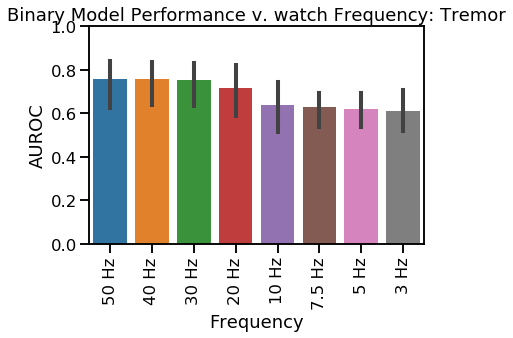

In [8]:
barplotFreq('watch','Tremor','Binary')
stats_tests('watch','Tremor','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.002412593591556447

50 Hz, 40 Hz, 30 Hz
p-value: 3.308916293724928e-16

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 7.38002503406109e-10

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.6506244858991778e-27

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.184477772472637e-38

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 4.3142582378241163e-44

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 3.430803892709112e-45

Maximum AUROC: 50 Hz

50 Hz, 40 Hz
Ttest_relResult(statistic=3.9152168914794387, pvalue=0.0024125935915402658)
50 Hz, 30 Hz
Ttest_relResult(statistic=16.226915208395546, pvalue=4.968144017365644e-09)
50 Hz, 20 Hz
Ttest_relResult(statistic=5.896847669922167, pvalue=0.00010358995076898768)
50 Hz, 10 Hz
Ttest_relResult(statistic=23.837949575577834, pvalue=8.068836811438863e-11)
50 Hz, 7.5 Hz
Ttest_relResult(statistic=23.037107817080123, pvalue=1.1670808508118196e-10)
50 Hz, 5 Hz
Ttest_relResult(statistic=21.6336

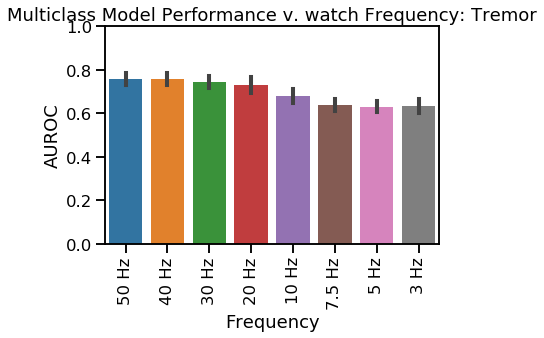

In [36]:
barplotFreq('watch','Tremor','Multiclass')
stats_tests('watch','Tremor','Multiclass')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.12395217547276298

50 Hz, 40 Hz, 30 Hz
p-value: 0.06442326741420444

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.04952154634148603

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.028517383719912175

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.1953483966683487

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.38931024076739873

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.2501306062572625

Maximum AUROC: 3 Hz

3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 10 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 7.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)


C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


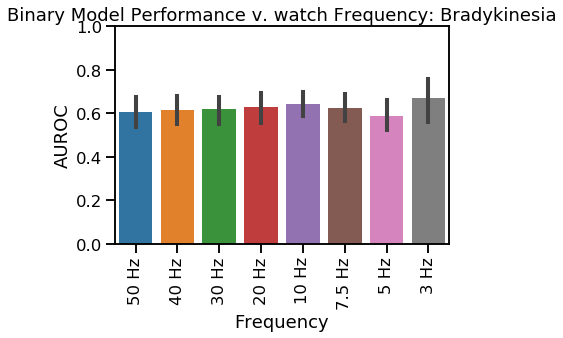

In [37]:
barplotFreq('watch','Bradykinesia','Binary')
stats_tests('watch','Bradykinesia','Binary')

Repeated Measures ANOVA
50 Hz, 40 Hz
p-value: 0.0009087538489185139

50 Hz, 40 Hz, 30 Hz
p-value: 0.0020617771613268008

50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.01697286221030063

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.00401187836205403

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.05866386565173557

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 1.1830895688722739e-08

50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 3.2679416914300967e-07

Maximum AUROC: 10 Hz

10 Hz, 50 Hz
Ttest_relResult(statistic=3.287637792341316, pvalue=0.0072349996975476704)
10 Hz, 40 Hz
Ttest_relResult(statistic=1.6050472278213983, pvalue=0.1367857526569272)
10 Hz, 30 Hz
Ttest_relResult(statistic=2.196702374653034, pvalue=0.05037538093202782)
10 Hz, 20 Hz
Ttest_relResult(statistic=1.7776743298940434, pvalue=0.10307895598765089)
10 Hz, 7.5 Hz
Ttest_relResult(statistic=5.358181250789192, pvalue=0.00023090933752353148)
10 Hz, 5 Hz
Ttest_relResult(statistic=8.2925099734509, pval

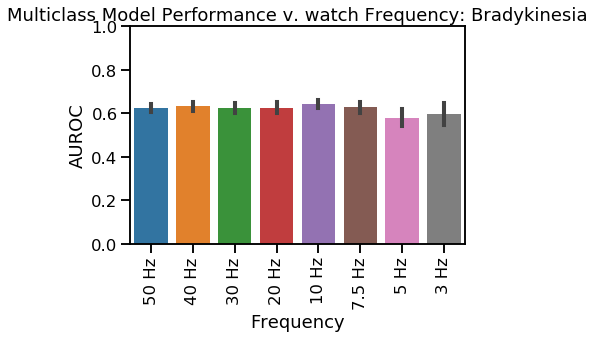

In [38]:
barplotFreq('watch','Bradykinesia','Multiclass')
stats_tests('watch','Bradykinesia','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.007827376842616335

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.18849919574820112

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.3197575505642747

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.5522942127795561

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.04523196179008014

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 6.022844208333385e-14

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 8.395045665713843e-18

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 3.371026885337091e-24

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 5.12193059234983e-15

Maximum AUROC: 40 Hz

40 Hz, 62.5 Hz
Ttest_relResult(statistic=1.350128823293323, pvalue=0.20673919547488567)
40 Hz, 60 Hz
Ttest_relResult(statistic=0.34992692845754103, pvalue=0.7336514326870405)
40 Hz, 50 Hz
Ttest_relResult(statistic=0.5721995545311576, pvalue=0.579821932810012)
40 Hz, 30 Hz
Ttest_relResult(st

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


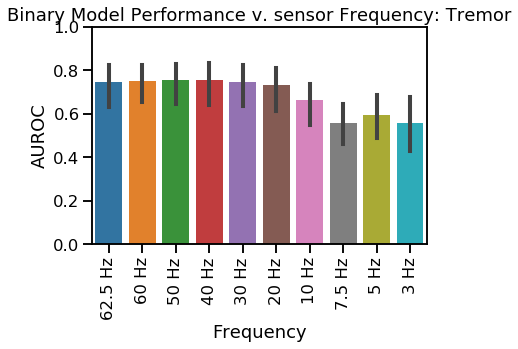

In [39]:
barplotFreq('sensor','Tremor','Binary')
stats_tests('sensor','Tremor','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.01610170079935148

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.000144702641928324

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 9.713954665333661e-06

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 7.155808299807187e-09

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 4.554661365275391e-18

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 3.8208461673512467e-47

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 1.639783213835194e-53

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 6.2091686013900775e-52

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 4.476521079280527e-33

Maximum AUROC: 50 Hz

50 Hz, 62.5 Hz
Ttest_relResult(statistic=3.8030526178112103, pvalue=0.0029277645868846405)
50 Hz, 60 Hz
Ttest_relResult(statistic=3.7433863817050415, pvalue=0.0032470166513375136)
50 Hz, 40 Hz
Ttest_relResult(statistic=3.6880379758853885, pvalue=0.0035753627037072738)
50 Hz, 30 H

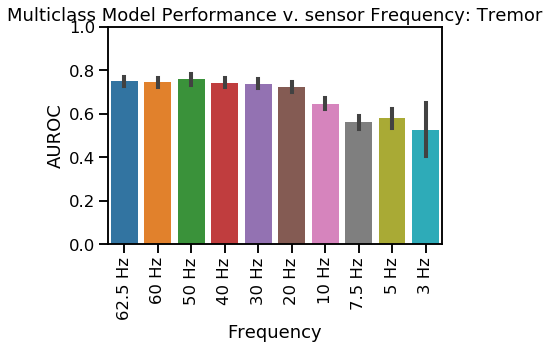

In [40]:
barplotFreq('sensor','Tremor','Multiclass')
stats_tests('sensor','Tremor','Multiclass')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.3331106359962581

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.6538848452624352

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.8061204401089056

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 0.9212850896607915

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 0.7424189426913445

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 0.40434775214684454

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 0.7682250104496846

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 0.32294120390074454

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 0.5789718612710187

Maximum AUROC: 3 Hz

3 Hz, 62.5 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 60 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 50 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 40 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 30 Hz
Ttest_relResult(statistic=nan, pvalue=nan)
3 Hz, 20 Hz
Ttest_relResult(

C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\nshawen\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


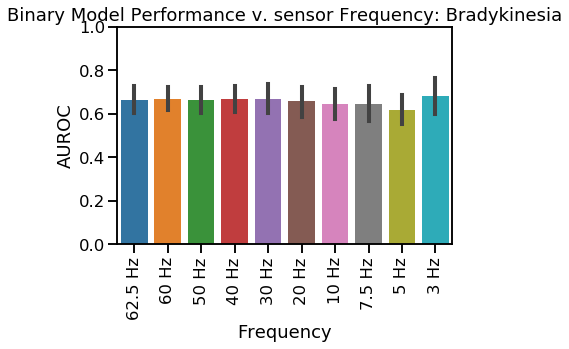

In [41]:
barplotFreq('sensor','Bradykinesia','Binary')
stats_tests('sensor','Bradykinesia','Binary')

Repeated Measures ANOVA
62.5 Hz, 60 Hz
p-value: 0.0014121350775747948

62.5 Hz, 60 Hz, 50 Hz
p-value: 0.0016450682116917912

62.5 Hz, 60 Hz, 50 Hz, 40 Hz
p-value: 0.0007920124380920538

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz
p-value: 1.3318965146697019e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz
p-value: 3.313931087763377e-07

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz
p-value: 1.7315181980497324e-20

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz
p-value: 6.006907012681223e-19

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz
p-value: 2.639137403545302e-39

62.5 Hz, 60 Hz, 50 Hz, 40 Hz, 30 Hz, 20 Hz, 10 Hz, 7.5 Hz, 5 Hz, 3 Hz
p-value: 2.609978597475186e-26

Maximum AUROC: 20 Hz

20 Hz, 62.5 Hz
Ttest_relResult(statistic=1.6499389876204793, pvalue=0.12718938686395626)
20 Hz, 60 Hz
Ttest_relResult(statistic=4.080717724667931, pvalue=0.001817982849019493)
20 Hz, 50 Hz
Ttest_relResult(statistic=4.148080896395525, pvalue=0.0016217098195078438)
20 Hz, 40 Hz


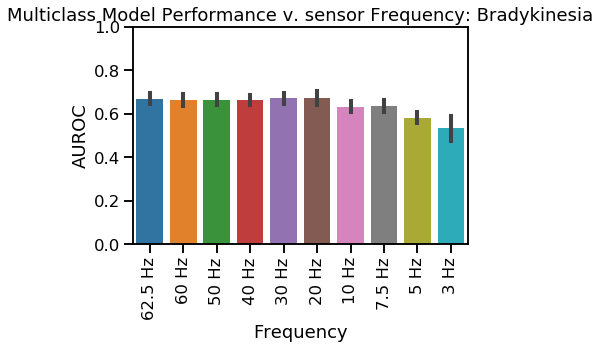

In [42]:
barplotFreq('sensor','Bradykinesia','Multiclass')
stats_tests('sensor','Bradykinesia','Multiclass')